# Deconstructed Raw Voltage Pipeline
This tutorial walks through the steps behind the RAW data pipeline, without recording to disk.

If you have access to a GPU, it is highly recommended to install CuPy, which performs the equivalent NumPy array operations on the GPU (https://docs.cupy.dev/en/stable/install.html). This is not necessary to run raw voltage generation, but will highly accelerate the pipeline. Once you have CuPy installed, to enable GPU acceleration you must set `SETIGEN_ENABLE_GPU` to '1' in the shell or in Python via `os.environ`. It can also be useful to set `CUDA_VISIBLE_DEVICES` to specify which GPUs to use.

In [1]:
# !pip install cupy-cuda110

In [1]:
import os
os.environ['SETIGEN_ENABLE_GPU'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cupy as xp
except ImportError:
    import numpy as xp
import numpy as np

from astropy import units as u
import blimpy as bl

import sys
sys.path.insert(0, "/mnt_home/bryanb/setigen/")
import setigen as stg

def get_numpy(v):
    try:
        return xp.asnumpy(v)
    except AttributeError:
        return v
    
def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

bshuf filter already loaded, skip it.
lz4 filter already loaded, skip it.
zfp filter already loaded, skip it.


In [3]:
# Sometimes it can be necessary to re-run this command for plots to show automatically
%matplotlib inline

We first set some basic parameters behind the pipeline. `sample_rate` is in samples per second (Hz); `num_taps` and `num_branches` are specific to the polyphase filterbank described below. 

In [ ]:
sample_rate = 3e9
num_taps = 8
num_branches = 1024

chan_bw = sample_rate / num_branches

## Creating an Antenna

We will start off with an `Antenna` object, as in the first tutorial. This time, we'll only use a single polarization. Showing noise (and converting from CuPy array if necessary).

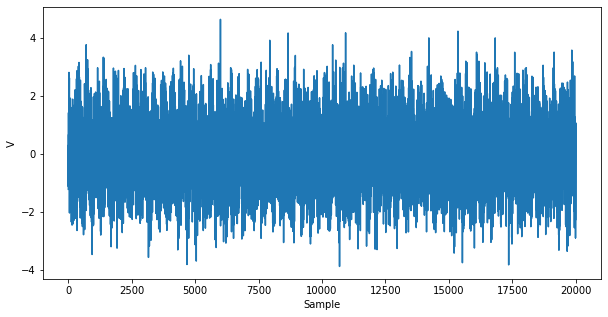

In [6]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

antenna.x.add_constant_signal(f_start=8e6, 
                              drift_rate=-2*u.Hz/u.s, 
                              level=0.5)

v = antenna.x.get_samples(20000)
    
plt.figure(figsize=(10, 5))
plt.plot(get_numpy(v))
plt.xlabel('Sample')
plt.ylabel('V')
plt.show()

## Getting real voltage samples and stepping through the pipeline

First, we gather enough samples to be able to eventually do a fine channelization. Here we plot a histogram showing the overall distribution of real voltages.

(90112,)


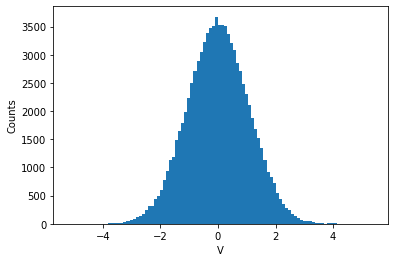

In [7]:
num_windows = 10
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

plt.hist(get_numpy(v), bins=100)
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

### Digitization

Next, we do our "digitization" step, which essentially scales the FWHM of the real voltage distribution to a desired FWHM for quantized data, which is constrained between `-2**(num_bits-1)` and `2**(num_bits-1)-1`. Plotting a histogram to show the same overall distribution:

(90112,)


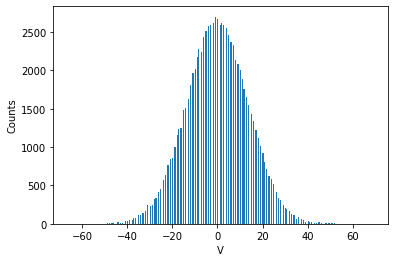

In [8]:
num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
                                      num_bits=num_bits)

v_q = digitizer.quantize(v)
print(v_q.shape)

plt.hist(get_numpy(v_q), bins=2**num_bits)
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

### Coarse channelization via Polyphase Filterbank

The quantized voltages are passed into a polyphase filterbank, and we obtain complex voltages from the real FFT. This produces `num_branches/2+1` coarse channels; in real systems, the last bin is dropped out so that we're left with `num_branches/2` effective coarse channels. Of course, you may truncate the resulting array to the desired range of coarse channels however you'd like after this step.

The shape of the data directly after channelization is `(time_samples, num_branches/2+1)`. If `num_samples=num_taps*num_branches*(num_windows+1)`, then `time_samples=num_taps*num_windows`, by design. This yields an easy formula for determing the number of real voltage samples necessary to get the desired number of time samples in our raw complex voltage data; this is built into `RawVoltageBackend` in the higher level `setigen` voltage pipeline.

Plotting histograms of real and imaginary values after the rFFT:

(80, 512)


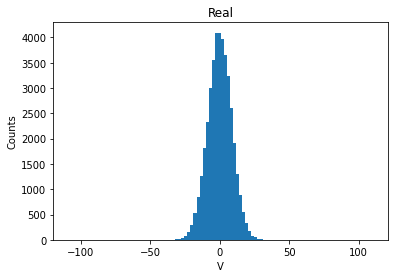

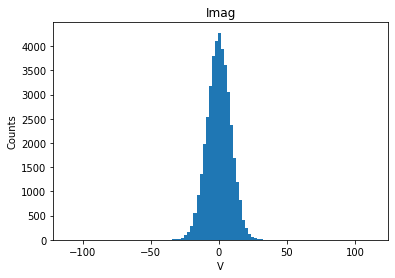

In [9]:
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

v_c = filterbank.channelize(v_q)
print(v_c.shape)

plt.hist(get_numpy(v_c.real.flatten()), bins=100)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

plt.hist(get_numpy(v_c.imag.flatten()), bins=100)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

In [10]:
v_c.real.std()

array(9.16478944)

We can also plot a spectrogram of the coarsely channelized data:

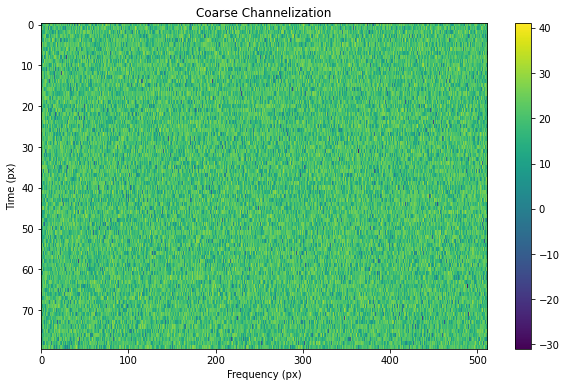

In [11]:
plt.figure(figsize=(10, 6))
plt.imshow(db(np.abs(get_numpy(v_c))**2), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Coarse Channelization")
plt.show()

### Requantization

The last data manipulation step is the requantization to either 8 or 4 bits, since these have a specific schema in GUPPI RAW format. That being said, the following cell will still work for alternate values. Plotting histograms here as well:

(80, 512)


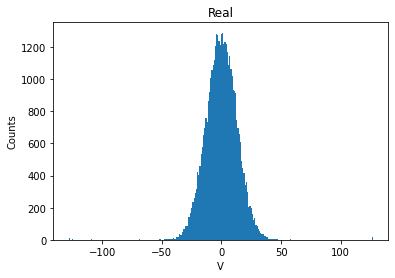

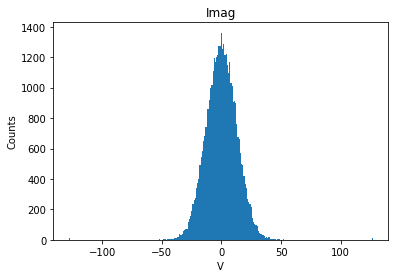

In [12]:
num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

v_rq = requantizer.quantize(v_c)
print(v_rq.shape)

plt.hist(get_numpy(v_rq.real.flatten()), bins=2**num_bits)
plt.title('Real')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

plt.hist(get_numpy(v_rq.imag.flatten()), bins=2**num_bits)
plt.title('Imag')
plt.xlabel('V')
plt.ylabel('Counts')
plt.show()

In [13]:
v_rq.imag.std()

array(13.45391337)

In [14]:
v_rq.real.std()

array(13.48954581)

In the standard pipeline, this is where we'd truncate to the desired range of coarse channels and save to GUPPI RAW format.

## Fine channelization
We can do a quick fine channelization to find the injected signal. Note that since we only have a few samples in the time direction, our fftlength can't be too large, but we can still clearly recover the injected signal:

Spectrogram shape: (10, 512)


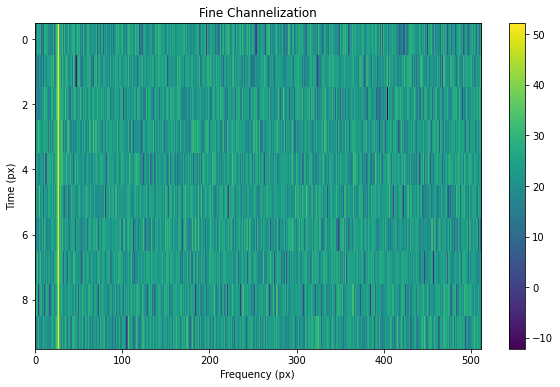

In [15]:
# Truncate coarse channels to the first 64.
v_tr = v_rq[:, 0:64]

psd = stg.voltage.get_pfb_waterfall(v_tr, int_factor=1, fftlength=8)
print(f"Spectrogram shape: {psd.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

Integrating over time:

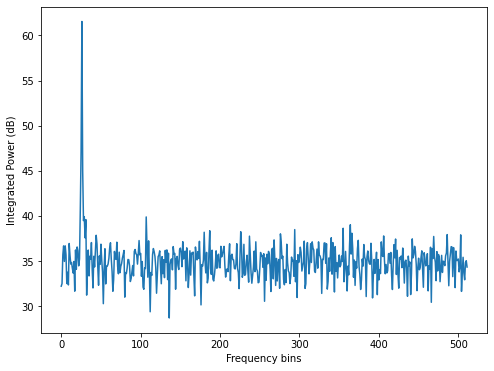

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(db(np.sum(get_numpy(psd), axis=0)))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

In [17]:
v_rq_data = v_rq

Adding only signal

(90112,)
Spectrogram shape: (10, 512)


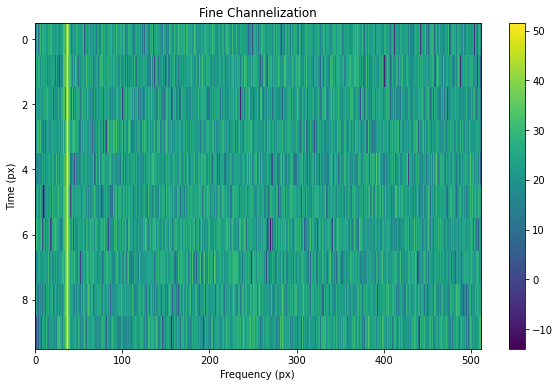

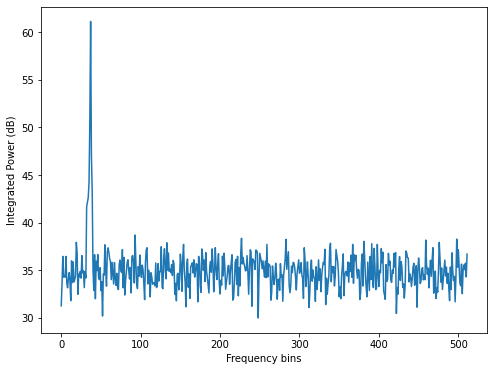

In [22]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

antenna.x.add_constant_signal(f_start=12e6, 
                              drift_rate=-2*u.Hz/u.s, 
                              level=0.5)

v = antenna.x.get_samples(20000)

num_windows = 10
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

# num_bits = 8
# target_fwhm = 32 * 2**num_bits / 2**8
# digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
#                                       num_bits=num_bits)

# v_q = digitizer.quantize(v)
# print(v_q.shape)

# plt.hist(get_numpy(v_q), bins=2**num_bits)
# plt.xlabel('V')
# plt.ylabel('Counts')
# plt.show()

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

v_c = filterbank.channelize(v)

num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

v_rq = requantizer.quantize(v_c)


# Truncate coarse channels to the first 64.
v_tr = v_rq[:, 0:64]

psd = stg.voltage.get_pfb_waterfall(v_tr, int_factor=1, fftlength=8)
print(f"Spectrogram shape: {psd.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(db(np.sum(get_numpy(psd), axis=0)))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

v_rq_data = v_rq

(90112,)
Spectrogram shape: (10, 512)


<ipython-input-3-e25cc4074e63>:28: RuntimeWarning: divide by zero encountered in log10
  return 10*np.log10(x)


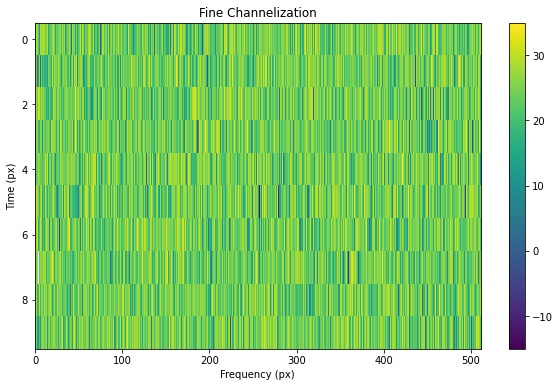

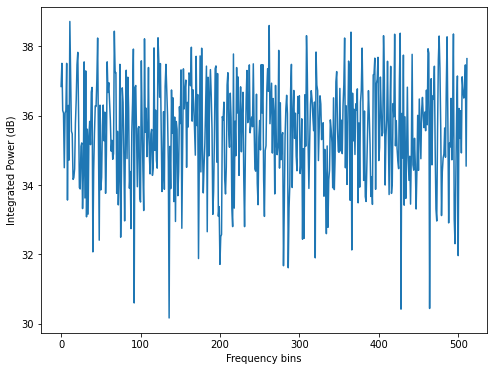

In [23]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_constant_signal(f_start=12e6, 
#                               drift_rate=-2*u.Hz/u.s, 
#                               level=0.5)

v = antenna.x.get_samples(20000)

num_windows = 10
num_samples = num_taps * num_branches * (num_windows + 1)

v = antenna.x.get_samples(num_samples)
print(v.shape)

# num_bits = 8
# target_fwhm = 32 * 2**num_bits / 2**8
# digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
#                                       num_bits=num_bits)

# v_q = digitizer.quantize(v)
# print(v_q.shape)

# plt.hist(get_numpy(v_q), bins=2**num_bits)
# plt.xlabel('V')
# plt.ylabel('Counts')
# plt.show()

filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

v_c = filterbank.channelize(v)

num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
requantizer = stg.voltage.ComplexQuantizer(target_fwhm=target_fwhm,
                                           num_bits=num_bits)

v_rq = requantizer.quantize(v_c)


# Truncate coarse channels to the first 64.
v_tr = v_rq[:, 0:64]

psd = stg.voltage.get_pfb_waterfall(v_tr, int_factor=1, fftlength=8)
print(f"Spectrogram shape: {psd.shape}")

plt.figure(figsize=(10, 6))
plt.imshow(db(get_numpy(psd)), 
           cmap='viridis', 
           aspect='auto', 
           interpolation='none')
plt.colorbar()
plt.xlabel("Frequency (px)")
plt.ylabel("Time (px)")
plt.title("Fine Channelization")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(db(np.sum(get_numpy(psd), axis=0)))
plt.xlabel("Frequency bins")
plt.ylabel("Integrated Power (dB)")
plt.show()

v_rq_data = v_rq

In [69]:
sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_constant_signal(f_start=12e6, 
#                               drift_rate=-2*u.Hz/u.s, 
#                               level=0.5)

v = antenna.x.get_samples(2000*1024)
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

print(v.mean(), v.std())
v_c = filterbank.channelize(v)
print(v_c.real.mean(), v_c.real.std())
print(v_c.imag.mean(), v_c.imag.std())

-0.0005016806183222012 0.9994636408318787
-0.0008148943094995081 0.6741650510274363
0.00043171686540249095 0.672307136094871


In [62]:
9.16478944/13.6

0.6738815764705882

In [65]:
0.673*2**0.5

0.9517657274770931

In [66]:
vars(filterbank)

{'num_taps': 8,
 'num_branches': 1024,
 'window_fn': 'hamming',
 'cache': [[array([ 0.23904164, -0.36288894, -0.35416189, ..., -0.1970651 ,
          -1.85915129, -0.67700131]),
   None]],
 'window': array([-7.83350901e-05, -2.35062326e-04, -3.91865779e-04, ...,
        -3.91865779e-04, -2.35062326e-04, -7.83350901e-05]),
 'max_mean_ratio': array(1.11018559)}

In [68]:
filterbank.window.std()

array(2.50179602)

In [70]:
V = v.reshape((2000, 1024))
V_pfb = np.fft.rfft(V, num_branches, axis=1) / num_branches**0.5

print(V_pfb.real.mean(), V_pfb.real.std())
print(V_pfb.imag.mean(), V_pfb.imag.std())

-0.0008289881443618196 0.708415779908209
0.00046574770467974194 0.7049769403382617


In [71]:
1/2**0.5

0.7071067811865475

In [72]:
0.6741650510274363/0.708415779908209

0.9516516573286796

In [73]:
0.672307136094871/0.7049769403382617

0.9536583363596047

In [76]:
num_taps = 8
num_branches = 1024

sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_constant_signal(f_start=12e6, 
#                               drift_rate=-2*u.Hz/u.s, 
#                               level=0.5)

v = antenna.x.get_samples(2000*num_branches)
filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

print(v.mean(), v.std())
print('==========')

v_c = filterbank.channelize(v)
print(v_c.real.mean(), v_c.real.std())
print(v_c.imag.mean(), v_c.imag.std())
print('==========')

V = v.reshape((2000, num_branches))
V_pfb = np.fft.rfft(V, num_branches, axis=1) / num_branches**0.5

print(V_pfb.real.mean(), V_pfb.real.std())
print(V_pfb.imag.mean(), V_pfb.imag.std())

0.000639363108900022 1.0000186303778482
-0.0004049597602824486 0.6742046464851145
5.367592602747008e-05 0.6728256633619438
-0.0004557402188933003 0.7086220325643466
1.7752992722306962e-05 0.7056446782371294


In [15]:
num_taps = 8
num_branches = 1024

sample_rate = 3e9
antenna = stg.voltage.Antenna(sample_rate=sample_rate, 
                              fch1=0*u.GHz,
                              ascending=True,
                              num_pols=1)

antenna.x.add_noise(v_mean=0, 
                    v_std=1)

# antenna.x.add_constant_signal(f_start=12e6, 
#                               drift_rate=-2*u.Hz/u.s, 
#                               level=0.5)

v = antenna.x.get_samples(2000*num_branches)

num_bits = 8
target_fwhm = 32 * 2**num_bits / 2**8
digitizer = stg.voltage.RealQuantizer(target_fwhm=target_fwhm,
                                      num_bits=num_bits)

v = digitizer.quantize(v)


filterbank = stg.voltage.PolyphaseFilterbank(num_taps=num_taps, 
                                             num_branches=num_branches)

print(v.mean(), v.std())
print('==========')

v_c = filterbank.channelize(v)
print(v_c.real.mean(), v_c.real.std())
print(v_c.imag.mean(), v_c.imag.std())
print('==========')

V = v.reshape((2000, num_branches))
V_pfb = np.fft.rfft(V, num_branches, axis=1) / num_branches**0.5

print(V_pfb.real.mean(), V_pfb.real.std())
print(V_pfb.imag.mean(), V_pfb.imag.std())

-0.03204736328125 13.649250094502927
-0.013570209663568294 9.202979116377218
-0.010684585881777186 9.184025549223605
-0.015245157163742683 9.666033794380116
-0.010579459726078268 9.636687477093583


In [16]:
filterbank.channelized_stds * digitizer.target_std

array([9.15825429, 9.14350228])

In [19]:
vars(digitizer)

{'target_mean': 0,
 'target_fwhm': 32.0,
 'target_std': array(13.5891488),
 'num_bits': 8,
 'stats_cache': [[(array(0.00291989), array(0.99636732)), [None, None]]],
 'stats_calc_indices': [[0, 0]],
 'stats_calc_period': 1,
 'stats_calc_num_samples': 10000}

In [17]:
digitizer.target_std/2**0.5

array(9.60897927)

In [120]:
vars(filterbank)

{'num_taps': 8,
 'num_branches': 1024,
 'window_fn': 'hamming',
 'cache': [[array([-0.67059242,  0.61270517, -1.66778252, ...,  1.19599103,
           1.25731416,  0.42994881]),
   None]],
 'window': array([-7.83350901e-05, -2.35062326e-04, -3.91865779e-04, ...,
        -3.91865779e-04, -2.35062326e-04, -7.83350901e-05]),
 'max_mean_ratio': array(1.11018559),
 'channelized_stds': (array(0.67452262), array(0.67337083))}

In [5]:
v_c.shape

(1992, 512)

In [9]:
v_c = v_c[:, 1:]
print(v_c.real.mean(), v_c.real.std())
print(v_c.imag.mean(), v_c.imag.std())

-0.00023588766254232732 0.6743090379732002
0.000544250967753742 0.6731625023397175
